**IMPORT PACKAGES**

In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

**LOAD DATASET**

In [2]:
path = 'C:/datasets/datasets/'
os.listdir(path)

['data_offers.csv', 'data_orders.csv', 'globalterrorismdb_0718dist.tar.bz2']

In [3]:
data_offers = pd.read_csv(path + 'data_offers.csv')
data_orders = pd.read_csv(path + 'data_orders.csv')

**BUSINESS UNDERSTANDING**

Gett, previously known as GetTaxi, is an Israeli-developed technology platform solely focused on corporate Ground Transportation Management (GTM). They have an application where clients can order taxis, and drivers can accept their rides (offers). At the moment, when the client clicks the Order button in the application, the matching system searches for the most relevant drivers and offers them the order. In this task, we would like to investigate some matching metrics for orders that did not completed successfully, i.e., the customer didn't end up getting a car.

Please complete the following tasks.

1. Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?

2. Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?

3. Plot the average time to cancellation with and without driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?

4. Plot the distribution of average ETA by hours. How can this plot be explained?

**DATA UNDERSTANDING**

We have two data sets: data_orders and data_offers, both being stored in a CSV format.

The data_orders data set contains the following columns:

- **order_datetime** - time of the order
- **origin_longitude** - longitude of the order
- **origin_latitude** - latitude of the order
- **m_order_eta** - time before order arrival
- **order_gk** - order number
- **order_status_key** - status, an enumeration consisting of the following mapping:
    - **4** - cancelled by client,
    - **9** - cancelled by system, i.e., a reject
- **is_driver_assigned_key** - whether a driver has been assigned
- **cancellation_time_in_seconds** - how many seconds passed before cancellation

The data_offers data set is a simple map with 2 columns:

- **order_gk** - order number, associated with the same column from the orders data set
- **offer_id** - ID of an offer

In [4]:
data_orders.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


In [5]:
data_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_datetime                 10716 non-null  object 
 1   origin_longitude               10716 non-null  float64
 2   origin_latitude                10716 non-null  float64
 3   m_order_eta                    2814 non-null   float64
 4   order_gk                       10716 non-null  int64  
 5   order_status_key               10716 non-null  int64  
 6   is_driver_assigned_key         10716 non-null  int64  
 7   cancellations_time_in_seconds  7307 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 669.9+ KB


In [6]:
data_offers.head()

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


In [7]:
data_offers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334363 entries, 0 to 334362
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   order_gk  334363 non-null  int64
 1   offer_id  334363 non-null  int64
dtypes: int64(2)
memory usage: 5.1 MB


**Data Preparation**

- **Data Cleansing**

1. Check Missing Value

In [8]:
missing_value_orders = pd.isnull(data_orders).sum()
missing_value_orders

order_datetime                      0
origin_longitude                    0
origin_latitude                     0
m_order_eta                      7902
order_gk                            0
order_status_key                    0
is_driver_assigned_key              0
cancellations_time_in_seconds    3409
dtype: int64

In [9]:
rasio = missing_value_orders.div(len(data_orders))
rasio

order_datetime                   0.000000
origin_longitude                 0.000000
origin_latitude                  0.000000
m_order_eta                      0.737402
order_gk                         0.000000
order_status_key                 0.000000
is_driver_assigned_key           0.000000
cancellations_time_in_seconds    0.318122
dtype: float64

In [10]:
data_orders['m_order_eta'].describe()

count    2814.000000
mean      441.415423
std       288.006379
min        60.000000
25%       233.000000
50%       368.500000
75%       653.000000
max      1559.000000
Name: m_order_eta, dtype: float64

In [11]:
data_orders['m_order_eta'].fillna(int(data_orders['m_order_eta'].mean()), inplace=True)

In [12]:
data_orders['m_order_eta'].describe()

count    10716.000000
mean       441.109089
std        147.567669
min         60.000000
25%        441.000000
50%        441.000000
75%        441.000000
max       1559.000000
Name: m_order_eta, dtype: float64

In [13]:
data_orders['cancellations_time_in_seconds'].describe()

count    7307.000000
mean      157.892021
std       213.366963
min         3.000000
25%        45.000000
50%        98.000000
75%       187.500000
max      4303.000000
Name: cancellations_time_in_seconds, dtype: float64

In [14]:
data_orders['cancellations_time_in_seconds'].fillna(int(data_orders['cancellations_time_in_seconds'].mean()), inplace=True)

In [15]:
data_orders['cancellations_time_in_seconds'].describe()

count    10716.000000
mean       157.608249
std        176.186298
min          3.000000
25%         67.000000
50%        157.000000
75%        157.000000
max       4303.000000
Name: cancellations_time_in_seconds, dtype: float64

In [16]:
pd.isnull(data_orders).sum()

order_datetime                   0
origin_longitude                 0
origin_latitude                  0
m_order_eta                      0
order_gk                         0
order_status_key                 0
is_driver_assigned_key           0
cancellations_time_in_seconds    0
dtype: int64

In [17]:
pd.isnull(data_offers).sum()

order_gk    0
offer_id    0
dtype: int64

2. Check Duplicate Data

In [18]:
data_orders[data_orders['order_gk'].duplicated(keep=False)].sort_values(['order_gk'])

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds


In [19]:
data_offers[data_offers['order_gk'].duplicated(keep=False)].sort_values(['order_gk'])

,order_gk,offer_id
253839,3000551431560,300050591209
215287,3000551431560,300050591208
195130,3000551431566,300050591221
65034,3000551431566,300050591214
23441,3000551431566,300050591217
...,...,...
334199,3000633196163,300052444785
40852,3000633196174,300052444792
222810,3000633196174,300052444798
132607,3000633196222,300052444836


In [20]:
duplicated = data_offers['order_gk'].duplicated().sum()
duplicated

236396

In [21]:
data_offers = data_offers.drop_duplicates(subset=['order_gk'])

In [22]:
data_offers[data_offers.order_gk.duplicated(keep=False)].sort_values("order_gk")

,order_gk,offer_id


3. Standardize and Normalize Data

<Axes: >

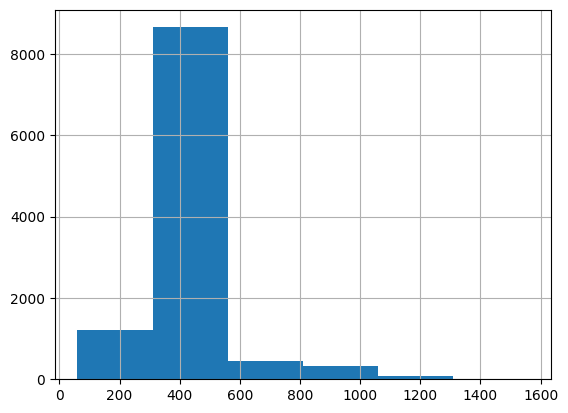

In [23]:
data_orders['m_order_eta'].hist(bins=6)

In [24]:
data_orders['m_order_eta_stand'] = (data_orders['m_order_eta']-data_orders['m_order_eta'].mean())/(data_orders['m_order_eta'].std())

In [25]:
data_orders['m_order_eta_stand'].describe()

count    1.071600e+04
mean    -4.044709e-17
std      1.000000e+00
min     -2.582606e+00
25%     -7.392487e-04
50%     -7.392487e-04
75%     -7.392487e-04
max      7.575446e+00
Name: m_order_eta_stand, dtype: float64

<Axes: >

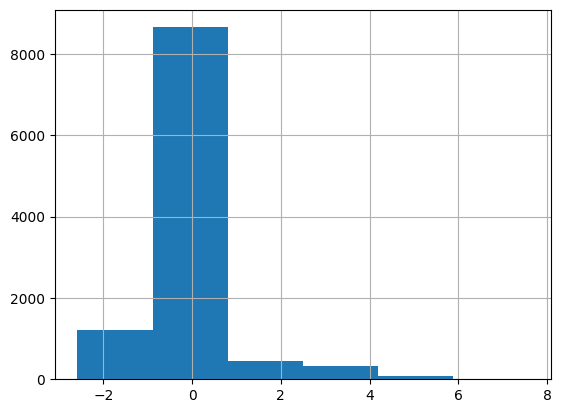

In [26]:
data_orders['m_order_eta_stand'].hist(bins=6)

In [27]:
data_orders['m_order_eta_norm'] = (data_orders['m_order_eta']-data_orders['m_order_eta'].min())/(data_orders['m_order_eta'].max()-data_orders['m_order_eta'].min())

In [28]:
data_orders['m_order_eta_norm'].describe()

count    10716.000000
mean         0.254242
std          0.098444
min          0.000000
25%          0.254169
50%          0.254169
75%          0.254169
max          1.000000
Name: m_order_eta_norm, dtype: float64

In [29]:
data_orders[['m_order_eta', 'm_order_eta_stand', 'm_order_eta_norm']].head()

,m_order_eta,m_order_eta_stand,m_order_eta_norm
0,60.0,-2.582606,0.000000
1,441.0,-0.000739,0.254169
2,477.0,0.243217,0.278185
3,658.0,1.469773,0.398933
4,441.0,-0.000739,0.254169


- **Data Manipulation**

1. Checking and Changing Data Type

In [30]:
data_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_datetime                 10716 non-null  object 
 1   origin_longitude               10716 non-null  float64
 2   origin_latitude                10716 non-null  float64
 3   m_order_eta                    10716 non-null  float64
 4   order_gk                       10716 non-null  int64  
 5   order_status_key               10716 non-null  int64  
 6   is_driver_assigned_key         10716 non-null  int64  
 7   cancellations_time_in_seconds  10716 non-null  float64
 8   m_order_eta_stand              10716 non-null  float64
 9   m_order_eta_norm               10716 non-null  float64
dtypes: float64(6), int64(3), object(1)
memory usage: 837.3+ KB


In [31]:
data_orders['order_status_key'] = np.where(data_orders['order_status_key']==4, 'Client Cancelled', 'System Rejected')
data_orders['is_driver_assigned_key'] = np.where(data_orders['is_driver_assigned_key']==1, 'Yes', 'No')

In [32]:
data_orders['order_datetime'] = pd.to_datetime(data_orders['order_datetime'], format='%H:%M:%S').dt.time

In [33]:
data_orders['hour'] = pd.to_datetime(data_orders['order_datetime'], format='%H:%M:%S').dt.hour

In [34]:
data_orders['hour'] = data_orders['hour'].astype(int)

In [35]:
data_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_datetime                 10716 non-null  object 
 1   origin_longitude               10716 non-null  float64
 2   origin_latitude                10716 non-null  float64
 3   m_order_eta                    10716 non-null  float64
 4   order_gk                       10716 non-null  int64  
 5   order_status_key               10716 non-null  object 
 6   is_driver_assigned_key         10716 non-null  object 
 7   cancellations_time_in_seconds  10716 non-null  float64
 8   m_order_eta_stand              10716 non-null  float64
 9   m_order_eta_norm               10716 non-null  float64
 10  hour                           10716 non-null  int32  
dtypes: float64(6), int32(1), int64(1), object(3)
memory usage: 879.2+ KB


In [36]:
data_offers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97967 entries, 0 to 334361
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   order_gk  97967 non-null  int64
 1   offer_id  97967 non-null  int64
dtypes: int64(2)
memory usage: 2.2 MB


2. Renaming Columns

In [37]:
data_orders = data_orders.rename(columns={'m_order_eta': 'order_eta', 'order_gk': 'order_id', 'order_status_key': 'order_status',
                                          'is_driver_assigned_key': 'driver_assigned', 'cancellations_time_in_seconds': 'cancellations',
                                          'origin_longitude': 'longitude', 'origin_latitude': 'latitude'})

In [38]:
data_orders.head()

,order_datetime,longitude,latitude,order_eta,order_id,order_status,driver_assigned,cancellations,m_order_eta_stand,m_order_eta_norm,hour
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,Client Cancelled,Yes,198.0,-2.582606,0.000000,18
1,20:57:32,-0.950385,51.456843,441.0,3000583116437,Client Cancelled,No,128.0,-0.000739,0.254169,20
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,Client Cancelled,Yes,46.0,0.243217,0.278185,12
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,Client Cancelled,Yes,62.0,1.469773,0.398933,13
4,21:24:45,-0.967605,51.458236,441.0,3000583140877,System Rejected,No,157.0,-0.000739,0.254169,21


In [39]:
data_offers = data_offers.rename(columns={'order_gk': 'order_id'})

In [40]:
data_offers.head()

,order_id,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


3. Removing Data

In [41]:
data_orders = data_orders.drop(['m_order_eta_stand', 'm_order_eta_norm'], axis=1)

In [42]:
data_orders.head()

,order_datetime,longitude,latitude,order_eta,order_id,order_status,driver_assigned,cancellations,hour
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,Client Cancelled,Yes,198.0,18
1,20:57:32,-0.950385,51.456843,441.0,3000583116437,Client Cancelled,No,128.0,20
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,Client Cancelled,Yes,46.0,12
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,Client Cancelled,Yes,62.0,13
4,21:24:45,-0.967605,51.458236,441.0,3000583140877,System Rejected,No,157.0,21


- **Data Wrangling**

1. Merging

In [43]:
data = data_orders.merge(data_offers, on='order_id')
data.head()

,order_datetime,longitude,latitude,order_eta,order_id,order_status,driver_assigned,cancellations,hour,offer_id
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,Client Cancelled,Yes,198.0,18,300050983403
1,20:57:32,-0.950385,51.456843,441.0,3000583116437,Client Cancelled,No,128.0,20,300050986179
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,Client Cancelled,Yes,46.0,12,300050976275
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,Client Cancelled,Yes,62.0,13,300050977907
4,21:21:23,-0.947011,51.456380,441.0,3000583117054,System Rejected,No,157.0,21,300050986706


In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7610 entries, 0 to 7609
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   order_datetime   7610 non-null   object 
 1   longitude        7610 non-null   float64
 2   latitude         7610 non-null   float64
 3   order_eta        7610 non-null   float64
 4   order_id         7610 non-null   int64  
 5   order_status     7610 non-null   object 
 6   driver_assigned  7610 non-null   object 
 7   cancellations    7610 non-null   float64
 8   hour             7610 non-null   int32  
 9   offer_id         7610 non-null   int64  
dtypes: float64(4), int32(1), int64(2), object(3)
memory usage: 624.3+ KB


**EXPLORATORY DATA ANALYSIS**

1. Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?

In [45]:
driver_assigned = data.groupby(['driver_assigned', 'order_status'])['order_id'].count()
driver_assigned

driver_assigned  order_status    
No               Client Cancelled    3367
                 System Rejected     1903
Yes              Client Cancelled    2338
                 System Rejected        2
Name: order_id, dtype: int64

<Axes: title={'center': 'Distribution of Orders Accordig to Reasons for Failure'}, ylabel='Number of Order'>

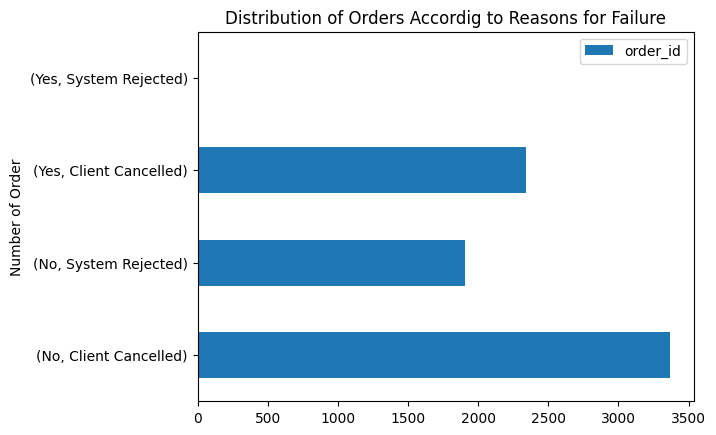

In [46]:
driver_assigned.plot(kind='barh', legend=True, subplots=False,
                    ylabel='Number of Order', title='Distribution of Orders Accordig to Reasons for Failure')

**Interpretation**

1. When drivers are not assigned, order failures due to client cancellations amounted to 3367 orders.
2. When the driver is not assigned, the order failure is due to a system error of 1903 orders.
3. When the driver is assigned, the order failure due to cancel from the client is 2338 orders
4. When the driver is assigned, the order failure due to system error is 2 orders.

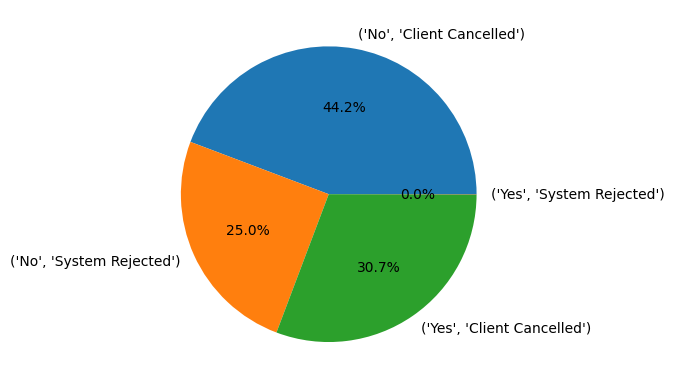

In [47]:
fig, ax = plt.subplots()
ax.pie(driver_assigned, labels=driver_assigned.index, autopct='%1.1f%%')
plt.show()


2. Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?

In [48]:
hour = data.groupby('hour')['order_id'].count().sort_values(ascending=False)
hour

hour
8     837
21    668
23    542
22    448
0     440
2     402
3     398
7     381
17    343
20    335
15    333
9     325
1     308
13    280
18    263
16    222
14    188
12    186
19    181
11    151
10    126
6     122
4      87
5      44
Name: order_id, dtype: int64

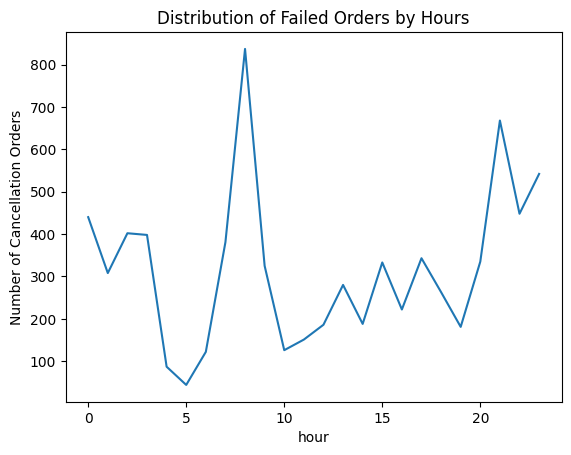

In [49]:
sns.lineplot(x=hour.index, y=hour.values)
plt.ylabel('Number of Cancellation Orders')
plt.title('Distribution of Failed Orders by Hours')
plt.show()

**Interpretation**

1. The largest order failure is at 8am with 837 orders, this may be due to high demand traffic so not all drivers can pick up all orders.
2. The least number of order failures is at 5 am, it can be assumed that at that time the demand by customers is not too much, so the driver can accept the order.

3. Plot the average time to cancellation with and without driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?

- **Handling Outlier**

1. Deteksi Outlier

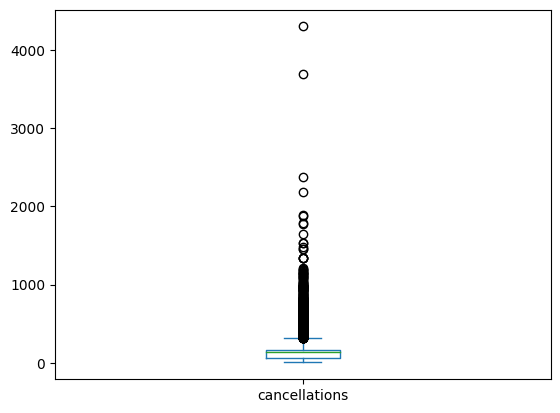

In [50]:
data['cancellations'].plot(kind='box', subplots=True, layout=(1, 1), sharex=False, sharey=False)
plt.show()

In [51]:
Q1 = data['cancellations'].quantile(0.25)
Q3 = data['cancellations'].quantile(0.75)

IQR = Q3 - Q1

detection = Q3 + 1.5 * IQR

outlier = data['cancellations'][(data['cancellations'] > detection)]
print(outlier)

11      316.0
15      475.0
21      527.0
30      418.0
34      593.0
        ...  
7572    461.0
7586    481.0
7593    501.0
7595    388.0
7600    833.0
Name: cancellations, Length: 591, dtype: float64


In [52]:
data = data.drop(outlier.index)
print(data)

     order_datetime  longitude   latitude  order_eta       order_id  \
0          18:08:07  -0.978916  51.456173       60.0  3000583041974   
1          20:57:32  -0.950385  51.456843      441.0  3000583116437   
2          12:07:50  -0.969520  51.455544      477.0  3000582891479   
3          13:50:20  -1.054671  51.460544      658.0  3000582941169   
4          21:21:23  -0.947011  51.456380      441.0  3000583117054   
...             ...        ...        ...        ...            ...   
7605       12:44:11  -0.975372  51.457846      441.0  3000597886155   
7606       12:42:52  -0.975372  51.457846      441.0  3000597886140   
7607       13:11:35  -0.975372  51.457846      441.0  3000599186906   
7608       13:17:21  -0.972926  51.457693       60.0  3000599187034   
7609       11:49:35  -0.974738  51.458180      177.0  3000592871241   

          order_status driver_assigned  cancellations  hour      offer_id  
0     Client Cancelled             Yes          198.0    18  3000509834

In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7019 entries, 0 to 7609
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   order_datetime   7019 non-null   object 
 1   longitude        7019 non-null   float64
 2   latitude         7019 non-null   float64
 3   order_eta        7019 non-null   float64
 4   order_id         7019 non-null   int64  
 5   order_status     7019 non-null   object 
 6   driver_assigned  7019 non-null   object 
 7   cancellations    7019 non-null   float64
 8   hour             7019 non-null   int32  
 9   offer_id         7019 non-null   int64  
dtypes: float64(4), int32(1), int64(2), object(3)
memory usage: 575.8+ KB


In [54]:
data.groupby(['hour', 'driver_assigned'])['cancellations'].mean().reset_index()

,hour,driver_assigned,cancellations
0,0,No,115.962536
1,0,Yes,125.089552
2,1,No,112.293103
3,1,Yes,99.148148
4,2,No,130.932722
5,2,Yes,117.468085
6,3,No,130.309524
7,3,Yes,88.650000
8,4,No,110.944444
9,4,Yes,88.880000


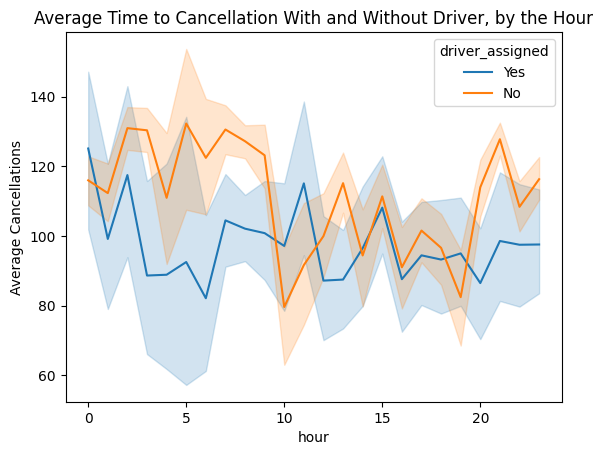

In [55]:
sns.lineplot(x='hour', y='cancellations', hue='driver_assigned', data=data)
plt.ylabel('Average Cancellations')
plt.title('Average Time to Cancellation With and Without Driver, by the Hour')
plt.show()

**Interpretation**

The average failed orders due to unassigned drivers is higher than the average failed orders due to assigned drivers. It can be concluded that more failed orders are caused by unassigned drivers, so that when a customer orders a taxi, there are not many available drivers, and the available drivers may have already gotten the order first. 

4. Plot the distribution of average ETA by hours. How can this plot be explained?

In [56]:
eta = data.groupby('hour')['order_eta'].mean().sort_values(ascending=False)
eta

hour
7     498.749280
8     497.392231
9     472.479310
12    452.184049
17    451.610932
15    449.231270
6     438.394495
16    438.132653
3     434.263298
21    430.822153
2     429.545455
23    428.206759
18    427.627119
5     425.400000
0     424.009662
22    422.571429
14    422.500000
13    420.488189
1     420.195804
19    411.641509
11    403.612403
20    403.444805
10    401.981982
4     369.696203
Name: order_eta, dtype: float64

<Axes: xlabel='hour'>

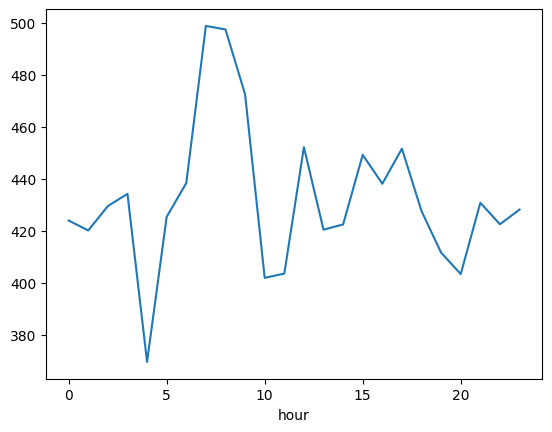

In [57]:
sns.lineplot(x=eta.index, y=eta.values)

**Interpretation**

The average ETA (which is the total time that orders have not arrived) per hour. It can be concluded that the distribution of time when orders have not arrived is highest at 7 am and the average time for orders that have not arrived is lowest at 4 am.

**Insight and Recommendation**

**Insight**

Based on the results of the analysis, it can be concluded that:

1. When drivers are not assigned, order failures due to client cancellations amounted to 3367 orders. When the driver is not assigned, the order failure is due to a system error of 1903 orders. When the driver is assigned, the order failure due to cancel from the client is 2338 orders. When the driver is assigned, the order failure due to system error is 2 orders.

2. The largest order failure was at 8 am with 837 orders, this may be due to high demand traffic so that not all drivers can take all orders and the least order failure was at 5 am, it can be assumed that at that time the demand by customers is not too much, so the driver can accept the order.

3. The average failed orders due to unassigned drivers is higher than the average failed orders due to assigned drivers. It can be concluded that more failed orders are caused by unassigned drivers, this can happen, so that when a customer orders a taxi, there are not many available drivers, and the available drivers may have already gotten the order first. 

4. the average ETA (which is the total time that orders have not arrived) per hour. it can be concluded that the distribution of time when orders have not arrived is highest at 7 am and the average time for orders that have not arrived is lowest at 4 am.

**Recommendation**

To be able to anticipate future order failures,

1. The company can arrange for more drivers to be assigned during peak hours or perhaps increase the number of drivers assigned, so that customer demand for the service provided can run according to the demand for the service.

2. Then the company also needs to fix errors in the system that can cause order failures due to this, by improving the quality of the service system so that the service can run well and the customer is satisfied with the service provided.

3. And the company must prioritize peak hours where during these hours, the demand for services from customers is high.